- This notebook contains experiments for the Amazon Games Dataset for the following models:

- **Updated PSI**

- **Regular PSI**

- **Pure SVD**

- **Most Pop**

- **Rand Rec**

## Imports

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "8"

In [ ]:
import io
import os
import gzip
import json
import scipy
import random
import warnings
import numpy as np
#import numba as nb
import pandas as pd
import datetime as dt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as st
from collections import OrderedDict
import scipy.sparse as sparse
from scipy.linalg import orth
import matplotlib.pyplot as plt
from numpy import linalg as lin
import implicit
import pickle
warnings.filterwarnings('ignore')
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from datetime import datetime as dt_dt
from scipy.sparse.linalg import spsolve
from numpy.linalg import qr as QR_decomp
from scipy.sparse import csr_matrix, find
from pandas.api.types import CategoricalDtype
from typing import List
import torch
import torch.nn.functional as F
from torch import nn
from polara.evaluation.pipelines import random_grid
import bottleneck as bn

## Functions

In [ ]:
import sys
sys.path.append('/home/oolaleke/incremental_PSI/Scripts/')
#sys.path.append('/content/')

In [ ]:
import a_DataHelpers
import b_AlgoFunctions
import c_PredEval
import d_CorrScores
import e_VAEfunction

In [ ]:
from a_DataHelpers import getPivotMonths,Time_DataSplit,TestTrain_DataSplit,SingleRatingMatrix
from a_DataHelpers import AllRatingMatrices,All_SingleStepRatMat,psiStep_RatMat,psiAllStep_RatMat
from a_DataHelpers import Find_NewUsersItems,adjustedPSI_DF,adjustedAllDF,get_NEWHoldout,ADJUST_mainDF
from a_DataHelpers import  SingleStepRatMat_2,AllSingleStepRatMat_2,SingleStep_RatMat

from b_AlgoFunctions import integrator,getStartingValues,integratorOnMat,last_psiTrainMat, pureSVD
from b_AlgoFunctions import Updt_RowMatrix,getRow_Mat,row_update, Updt_ColMatrix,getCol_Mat,colunm_update
from b_AlgoFunctions import UsersItems_RatPair,getRowCol_psiupdt,ITEMS_defferredStatus,USERS_defferredStatus
from b_AlgoFunctions import getV_listUpdate, SingleStep_UPDATE,ALLSTEPs_UPDATE
from b_AlgoFunctions import tune_ALS,auc_score,TrainTest,mean_auc
from b_AlgoFunctions import nonzeros,least_squares_cg,alternating_least_squares_cg
#from b_AlgoFunctions import topN_Index, TopNPred, HitrEval_noprint,SVDoptimalSearch

from c_PredEval import TopNPred,TQDMgetALLTopNPred, Hitrate_Eval,getAll_HitRate,mean_confidence_interval
from c_PredEval import TQDMgetALLTopNPred_ALLUSERS,getALLTopNPred_ALLUSERS,get_ALLRandPred
from c_PredEval import topN_Index,getAll_RandomHitRate,getMOSTPOP_Pred,getAll_MostPOPHitRate,getAll_MOSTPOP_Pred
from c_PredEval import StepCoverage_Ratio,AllSteps_Coverage_Ratio,getAll_VAEMRR
from c_PredEval import MRR_Eval,getAll_MRR_Eval,TQDMgetAll_MRR_Eval, getAll_MostPOP_MRR,getAll_RandomRecMRR
from c_PredEval import ials_TopNPred, ials_getALLPred, ials_getALLPredTQDM,ialsALLPred_ALLUSERS

from d_CorrScores import no_copy_csr_matrix,build_rank_weights_matrix,rank_weighted_jaccard_index
from d_CorrScores import Updt_getAll_AvgCorr, updtCorr_4AllRanks

from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat


In [ ]:
def HitrEval_noprint(Holdout,TopN_pred,user_column,item_column):
    Eval_itemsVector  =  Holdout[[item_column]].to_numpy()
    HitRate_arr   =  (TopN_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    return HitRate_

def SVDoptimalSearch(RatingMat,holdout,user_column,item_column,start,end,increment,N=10):
    AllHitrate = []
    max_hit = 0 
    for rank in tqdm(range(start,end+1,increment)): 
        Usvd, Ssvd, VTsvd = svds(RatingMat, k=rank)
        Vsvd = VTsvd.T
        top_k = TopNPred(RatingMat,holdout,Vsvd, user_column, N)
        hit_r = HitrEval_noprint(holdout,top_k,user_column,item_column)
        AllHitrate.append(hit_r)
        if hit_r > max_hit:
           max_hit =  hit_r
           max_rank = rank
           print("\n Max Rank: {} | HitRate:{}".format(max_rank, max_hit))
    print("\n Best-Params; Max Rank: {} | HitRate: {}".format(max_rank, max_hit))    
    return AllHitrate,max_hit,max_rank

In [ ]:
def TopN_RandomPred(RatingMat,user_column,N):  
    N_users,N_items = RatingMat.shape   
    PVVT_RandScores = np.random.rand(N_users,N_items)   ##Assigns random scores to items
    users_column = RatingMat.nonzero()[0]
    items_column = RatingMat.nonzero()[1]
    args = np.array([users_column,items_column])
    np.put(PVVT_RandScores, np.ravel_multi_index(args, PVVT_RandScores.shape),-np.inf)   ##downsample previously 
    TopN_pred = np.apply_along_axis(topN_Index, 1,PVVT_RandScores,n = N)
    return TopN_pred

def get_ALLRandPred(RatingMat_List,user_column,N):
    All_RandPred = []
    for RatingMat in tqdm(RatingMat_List):  
        Rand_pred =  TopN_RandomPred(RatingMat,user_column, N)
        All_RandPred.append(Rand_pred)
    return All_RandPred


**Apply Functions on AmazonGAMES**

# Data Preparation

**Data Import**

In [ ]:
#
AMZGames_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_IncreDF.csv') 
AMZGames_DF['timestamp'] = pd.to_datetime(AMZGames_DF['timestamp']) 
print(AMZGames_DF.shape)   #userId_int
print(AMZGames_DF.dtypes)
AMZGames_DF

(345213, 7)
userid                  object
ProductID               object
rating                   int64
timestamp       datetime64[ns]
timestamp_YM            object
userId                   int64
productId                int64
dtype: object


,userid,ProductID,rating,timestamp,timestamp_YM,userId,productId
0,A2AXQTB83VMK4L,B0000296O5,1,1999-10-14,1999-10,0,0
1,A2T04VAIXSKJH2,B00002NDRY,1,1999-11-05,1999-11,1,1
2,A1QA8K3LD9K892,B000021Y5F,1,1999-11-10,1999-11,2,2
3,A1QA8K3LD9K892,B000021Y5Q,1,1999-11-10,1999-11,2,3
4,ANLA598UNJI8A,B00001IVGE,1,1999-11-14,1999-11,3,4
...,...,...,...,...,...,...,...
345208,AXGJNBYPUNR2,B01FDA42PU,1,2018-09-29,2018-09,29226,16596
345209,ANS2OWH7CK1M9,B01GW8YDLK,1,2018-09-30,2018-09,3543,17319
345210,A1SDXNTHJ255P7,B01GW3H3U8,1,2018-10-01,2018-10,33517,16745
345211,A3R7Y70K7ZPJ3I,B01GKF824Y,1,2018-10-01,2018-10,35953,17045


In [ ]:
print(AMZGames_DF.shape)
print("For users: ")
print(AMZGames_DF['userId'].nunique())
print(AMZGames_DF['userId'].max())
print()
print("For items: ")
print(AMZGames_DF['productId'].nunique())
print(AMZGames_DF['productId'].max())
print()
print("Timestamp")
print(AMZGames_DF['timestamp'].min())
print(AMZGames_DF['timestamp'].max())

(345213, 7)
For users: 
39284
39283

For items: 
17320
17319

Timestamp
1999-10-14 00:00:00
2018-10-02 00:00:00


**Data Splitting**

In [ ]:
train_df = AMZGames_DF[AMZGames_DF['timestamp_YM'] < '2015-06']  
print(train_df['userid'].nunique())
print(train_df['userid'].shape)  ##63%

30238
(217772,)


In [ ]:
remainder_df = AMZGames_DF[AMZGames_DF['timestamp_YM'] >= '2015-06']  
print(remainder_df['userid'].nunique())
print(remainder_df.shape)

23371
(127441, 7)


In [ ]:
AMZGames_DF['userId']  #.unique()

n = 5550  #num_of_interaction/no_steps
all_df = []
for g, df in remainder_df.groupby(np.arange(len(remainder_df)) // n):
    all_df.append(df)
    print(df['userId'].nunique())
print()
print(g+1)    

2255
2215
2236
2293
2336
2362
2176
2225
2239
2408
2346
2259
2275
2290
2374
2311
2228
2269
2330
2302
2297
2294
2232

23


In [ ]:
A0_df = train_df  
print("Initial Training Data: ") 
print("Start Time: ",A0_df['timestamp'].min())
print("End Time:   ",A0_df['timestamp'].max())
print()
print("Num of interactions: ",A0_df.shape[0])
print("Num of uniqueUsers:  ",A0_df['userId'].nunique())

Initial Training Data: 
Start Time:  1999-10-14 00:00:00
End Time:    2015-05-31 00:00:00

Num of interactions:  217772
Num of uniqueUsers:   30238


In [ ]:
ΔA_train = all_df[:8] 
print("Incremental Train steps: ",len(ΔA_train))
print("Start Time: ",ΔA_train[0]['timestamp'].min())
print("End Time:   ",ΔA_train[-1]['timestamp'].max())

Incremental Train steps:  8
Start Time:  2015-06-01 00:00:00
End Time:    2016-02-14 00:00:00


In [ ]:
ΔA_test = all_df[8:] 
print("Incremental Test steps: ",len(ΔA_test))
print("Start Time: ",ΔA_test[0]['timestamp'].min())
print("End Time:   ",ΔA_test[-1]['timestamp'].max())

Incremental Test steps:  15
Start Time:  2016-02-14 00:00:00
End Time:    2018-10-02 00:00:00


In [ ]:
ΔA_test[0]['timestamp'].max()

Timestamp('2016-03-13 00:00:00')

In [ ]:
AllDF_list, PSITest_list, HOLDOUT_list,UserItemDF_list = TestTrain_DataSplit(AMZGames_DF,'userId','timestamp',ΔA_test)
print(AllDF_list[1]['timestamp'].min())
print(AllDF_list[1]['timestamp'].max())
print()
print(ΔA_test[1]['timestamp'].min())
print(ΔA_test[1]['timestamp'].max())

1999-10-14 00:00:00
2016-04-19 00:00:00

2016-03-13 00:00:00
2016-04-19 00:00:00


In [ ]:
for i in range(10):
    print(AllDF_list[i]['userId'].max(),AllDF_list[i]['userId'].nunique())

34705 34706
35124 35125
35482 35483
35886 35887
36314 36315
36662 36663
37003 37004
37346 37347
37698 37699
38004 38005


In [ ]:
print(AllDF_list[0].shape)
print(UserItemDF_list[0].shape)
print(HOLDOUT_list[0].shape)

(267723, 7)
(265446, 7)
(2239, 7)


**Find new users and items**

In [ ]:
Tstps = AMZGames_DF['timestamp']
tr_ts = ΔA_train[-1]['timestamp'].max()
print("ΔA_train_last max date: ",tr_ts)
AllDF_start = AMZGames_DF.loc[Tstps <= tr_ts] 
print(AllDF_start['timestamp'].min())
print(AllDF_start['timestamp'].max())
print()
print(AllDF_list[0]['timestamp'].min())
print(AllDF_list[0]['timestamp'].max())

ΔA_train_last max date:  2016-02-14 00:00:00
1999-10-14 00:00:00
2016-02-14 00:00:00

1999-10-14 00:00:00
2016-03-13 00:00:00


In [ ]:
New_usersList,New_itemsList = Find_NewUsersItems(AllDF_start,AllDF_list,'userId','productId',N_steps=15)
print(New_usersList[0][:10]) #
print()
print(New_itemsList[0][:10]) #

[34250 34251 34252 34253 34254 34255 34256 34257 34258 34259]

[16034 16035 16036 16037 16038 16039 16040 16041 16042 16043]


In [ ]:
print("users,Items")
for i,j in zip(New_usersList,New_itemsList):
    print(i.size,j.size)
    print()
    

users,Items
456 175

419 157

358 147

404 137

428 113

348 112

341 160

343 67

352 40

306 48

272 31

268 34

295 33

260 14

184 18



**Rank Tuning**

In [ ]:
###Rank Tuning:
newAMZGames_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_afterUpdt.csv')
print(newAMZGames_DF.shape)
newAMZGames_DF.head()

(345203, 9)


,userid,ProductID,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,A2AXQTB83VMK4L,B0000296O5,1,1999-10-14,1999-10,0,0,0,0
1,A2T04VAIXSKJH2,B00002NDRY,1,1999-11-05,1999-11,1,1,1,1
2,A1QA8K3LD9K892,B000021Y5F,1,1999-11-10,1999-11,2,2,2,2
3,A1QA8K3LD9K892,B000021Y5Q,1,1999-11-10,1999-11,2,3,2,3
4,ANLA598UNJI8A,B00001IVGE,1,1999-11-14,1999-11,3,4,3,4


In [ ]:

##lOAD Saved Lists...
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newHoldout.pkl', 'rb') as f:
     newHOLDOUT_LIST = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newPSITest.pkl', 'rb') as f:
    new_PSIDFlist = pickle.load(f)


In [ ]:
rows_i = newAMZGames_DF['Updated_UserID'].nunique()
cols_i = newAMZGames_DF['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) ##Same as UserItemMAT_regPSI
SVD_UserItemMAT

[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [ ]:
AllHitr_,maxhit,maxrank = SVDoptimalSearch(SVD_UserItemMAT[0],newHOLDOUT_LIST[0],'Updated_UserID','Updated_ItemID',start=10,end=200,increment=10,N=10)

  5%|▌         | 1/20 [00:00<00:14,  1.32it/s]
 Max Rank: 10 | HitRate:0.027254707631318136
 10%|█         | 2/20 [00:01<00:13,  1.36it/s]
 Max Rank: 20 | HitRate:0.031714568880079286
 15%|█▌        | 3/20 [00:02<00:13,  1.28it/s]
 Max Rank: 30 | HitRate:0.03617443012884044
 30%|███       | 6/20 [00:05<00:14,  1.04s/it]
 Max Rank: 60 | HitRate:0.04112983151635283
 35%|███▌      | 7/20 [00:06<00:14,  1.12s/it]
 Max Rank: 70 | HitRate:0.04261645193260654
 40%|████      | 8/20 [00:08<00:14,  1.21s/it]
 Max Rank: 80 | HitRate:0.04757185332011893
 65%|██████▌   | 13/20 [00:17<00:13,  1.90s/it]
 Max Rank: 130 | HitRate:0.048562933597621406
 75%|███████▌  | 15/20 [00:23<00:11,  2.25s/it]
 Max Rank: 150 | HitRate:0.050049554013875126
100%|██████████| 20/20 [00:43<00:00,  2.19s/it]
 Best-Params; Max Rank: 150 | HitRate: 0.050049554013875126



In [ ]:
rank_list = list(range(10,201,10))
print(rank_list)
print()
print(maxhit,maxrank )


[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]

0.050049554013875126 150


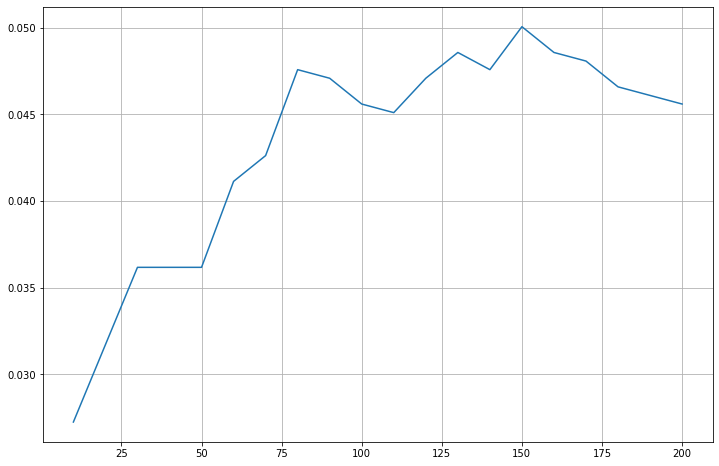

In [ ]:
plt.figure(figsize=(12,8))  
plt.plot(rank_list,AllHitr_)   ###Max == 150
plt.grid()

# Updated PSI

**Get RatingMatrices**

In [ ]:
rows_i = AllDF_start['userId'].nunique()
cols_i = AllDF_start['productId'].nunique()
print(A0_df.shape)
A0_RatMat_updt = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)
A0_RatMat_updt

(217772, 7)


<34250x16034 sparse matrix of type '<class 'numpy.float64'>'
	with 203890 stored elements in Compressed Sparse Row format>

In [ ]:
PSI_TrainMat_updt = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_TrainMat_updt

[<34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5390 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5394 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5404 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5391 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5440 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5436 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5439 stored elements in Compressed Sparse Row format>,
 <34250x16034 sparse matrix of type '<class 'numpy.float64'>'
 	with 5431 stored elements in Compressed Sparse Row format>]

**Allsteps Update**

In [ ]:
U_start,S_start,V_start = last_psiTrainMat(A0_RatMat_updt,PSI_TrainMat_updt,k=150)
print()
print("U_start shape: ",U_start.shape)
print("S_start shape: ",S_start.shape)
print("V_start shape: ",V_start.shape)

100%|██████████| 8/8 [00:01<00:00,  5.25it/s]
U_start shape:  (34250, 150)
S_start shape:  (150, 150)
V_start shape:  (16034, 150)



In [ ]:
U_list,S_list,V_list = [],[],[]
U_list.append(U_start)
S_list.append(S_start)
V_list.append(V_start)
print(len(U_list),len(V_list))

1 1


In [ ]:
DItems_, DUsers_,In_DomainUSERS,In_DomainITEMS,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,U_list,S_list,V_list = ALLSTEPs_UPDATE(AllDF_start,UserItemDF_list,New_itemsList,New_usersList,U_list,S_list,V_list,'userId','productId',Nsteps=15,k=150,Forced_Orth=False)

100%|██████████| 14/14 [07:50<00:00, 33.61s/it]


**Output Check**

In [ ]:
print(AllDF_start['productId'].max())
print(AllDF_start['userId'].max())

16033
34249


In [ ]:
print(len(In_DomainITEMS[16033+1:]))
print(In_DomainITEMS[16033+1:][:10])
print()
print(len(In_DomainUSERS[34249+1:]))
print(In_DomainUSERS[34249+1:][:10])

1284
[16034, 16035, 16037, 16039, 16040, 16044, 16046, 16047, 16048, 16049]

5034
[34251, 34252, 34253, 34254, 34255, 34256, 34257, 34258, 34259, 34260]


In [ ]:
#deferred items and users
print(len(DItems_))
print(DItems_[:10])
print()
print(len(DUsers_))
print(DUsers_[:10])

2
[17312, 17317]

0
[]


In [ ]:
for x in list(itemID_dict)[16033+1:][:50]:
    print ("Id: {}, UpdtId: {} ".format(x,  itemID_dict[x]))   ##id ==key || updtedid == values  ,itemID_dict

Id: 16034, UpdtId: 16034 
Id: 16035, UpdtId: 16035 
Id: 16037, UpdtId: 16036 
Id: 16039, UpdtId: 16037 
Id: 16040, UpdtId: 16038 
Id: 16044, UpdtId: 16039 
Id: 16046, UpdtId: 16040 
Id: 16047, UpdtId: 16041 
Id: 16048, UpdtId: 16042 
Id: 16049, UpdtId: 16043 
Id: 16050, UpdtId: 16044 
Id: 16051, UpdtId: 16045 
Id: 16052, UpdtId: 16046 
Id: 16054, UpdtId: 16047 
Id: 16055, UpdtId: 16048 
Id: 16056, UpdtId: 16049 
Id: 16058, UpdtId: 16050 
Id: 16061, UpdtId: 16051 
Id: 16062, UpdtId: 16052 
Id: 16065, UpdtId: 16053 
Id: 16067, UpdtId: 16054 
Id: 16068, UpdtId: 16055 
Id: 16069, UpdtId: 16056 
Id: 16070, UpdtId: 16057 
Id: 16072, UpdtId: 16058 
Id: 16073, UpdtId: 16059 
Id: 16074, UpdtId: 16060 
Id: 16075, UpdtId: 16061 
Id: 16076, UpdtId: 16062 
Id: 16077, UpdtId: 16063 
Id: 16078, UpdtId: 16064 
Id: 16079, UpdtId: 16065 
Id: 16080, UpdtId: 16066 
Id: 16082, UpdtId: 16067 
Id: 16083, UpdtId: 16068 
Id: 16085, UpdtId: 16069 
Id: 16087, UpdtId: 16070 
Id: 16089, UpdtId: 16071 
Id: 16090, U

In [ ]:
for x in list(userID_dict)[34249:][:50]:
    print ("Id: {}, UpdtId: {} ".format(x,  userID_dict[x]))   ##id ==key || updtedid == values 

Id: 34249, UpdtId: 34249 
Id: 34251, UpdtId: 34250 
Id: 34252, UpdtId: 34251 
Id: 34253, UpdtId: 34252 
Id: 34254, UpdtId: 34253 
Id: 34255, UpdtId: 34254 
Id: 34256, UpdtId: 34255 
Id: 34257, UpdtId: 34256 
Id: 34258, UpdtId: 34257 
Id: 34259, UpdtId: 34258 
Id: 34260, UpdtId: 34259 
Id: 34261, UpdtId: 34260 
Id: 34263, UpdtId: 34261 
Id: 34266, UpdtId: 34262 
Id: 34267, UpdtId: 34263 
Id: 34268, UpdtId: 34264 
Id: 34269, UpdtId: 34265 
Id: 34270, UpdtId: 34266 
Id: 34271, UpdtId: 34267 
Id: 34272, UpdtId: 34268 
Id: 34273, UpdtId: 34269 
Id: 34274, UpdtId: 34270 
Id: 34275, UpdtId: 34271 
Id: 34276, UpdtId: 34272 
Id: 34277, UpdtId: 34273 
Id: 34280, UpdtId: 34274 
Id: 34282, UpdtId: 34275 
Id: 34283, UpdtId: 34276 
Id: 34284, UpdtId: 34277 
Id: 34285, UpdtId: 34278 
Id: 34286, UpdtId: 34279 
Id: 34287, UpdtId: 34280 
Id: 34288, UpdtId: 34281 
Id: 34289, UpdtId: 34282 
Id: 34291, UpdtId: 34283 
Id: 34292, UpdtId: 34284 
Id: 34294, UpdtId: 34285 
Id: 34295, UpdtId: 34286 
Id: 34300, U

In [ ]:
print(len(U_list),len(V_list))
print(U_list[0].shape,V_list[0].shape)
print()
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape,v.shape)   

16 16
(34250, 150) (16034, 150)

(34576, 150) (16139, 150)
(35003, 150) (16295, 150)
(35393, 150) (16441, 150)
(35799, 150) (16570, 150)
(36209, 150) (16706, 150)
(36585, 150) (16820, 150)
(36929, 150) (16968, 150)
(37279, 150) (17072, 150)
(37644, 150) (17119, 150)
(37952, 150) (17162, 150)
(38235, 150) (17201, 150)
(38518, 150) (17235, 150)
(38811, 150) (17271, 150)
(39089, 150) (17293, 150)
(39284, 150) (17318, 150)


In [ ]:
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

34576 16139
35003 16295
35393 16441
35799 16570
36209 16706
36585 16820
36929 16968
37279 17072
37644 17119
37952 17162
38235 17201
38518 17235
38811 17271
39089 17293
39284 17318


In [ ]:
print(len(In_DomainUSERS),len(In_DomainITEMS))
print(AMZGames_DF['userId'].nunique(),AMZGames_DF['productId'].nunique())

39284 17318
39284 17320


**Data Adjustments**

In [ ]:
len(AllUpdtITEMS_)

15

In [ ]:

newHOLDOUT_LIST = get_NEWHoldout(HOLDOUT_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(len(newHOLDOUT_LIST))
print()
for old,new in zip(HOLDOUT_list,newHOLDOUT_LIST):
    print(old.shape[0],new.shape[0])

15it [00:00, 55.73it/s]15

2239 2018
2408 2200
2346 2172
2259 2079
2275 2089
2290 2120
2374 2217
2311 2207
2228 2133
2269 2171
2330 2261
2302 2246
2297 2196
2294 2269
2232 2222



In [ ]:
newUserItem_list = adjustedAllDF(UserItemDF_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print()
for df in newUserItem_list:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max())

15it [00:06,  2.46it/s]
34575 16138
35002 16294
35392 16440
35798 16569
36208 16705
36584 16819
36928 16967
37278 17071
37643 17118
37951 17161
38234 17200
38517 17234
38810 17270
39088 17292
39283 17317



In [ ]:
new_PSIDFlist = adjustedPSI_DF(PSITest_list,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
for old,new in zip(PSITest_list,new_PSIDFlist):
    print(old.shape[0],new.shape[0])

15it [00:00, 47.53it/s]3311 3310
3142 3140
3204 3204
3291 3291
3275 3275
3260 3260
3176 3175
3239 3238
3322 3321
3281 3280
3220 3220
3248 3248
3253 3252
3256 3256
3109 3109



In [ ]:
newAMZGames_DF = ADJUST_mainDF(AMZGames_DF,userID_dict,itemID_dict,AllUpdtUSERS_,AllUpdtITEMS_,'userId','productId')
print(newAMZGames_DF.shape)
print(newAMZGames_DF['userId'].max(),newAMZGames_DF['productId'].max())
print(newAMZGames_DF['userId'].nunique(),newAMZGames_DF['productId'].nunique())
print()
print(newAMZGames_DF['Updated_UserID'].max(),newAMZGames_DF['Updated_ItemID'].max())
print(newAMZGames_DF['Updated_UserID'].nunique(),newAMZGames_DF['Updated_ItemID'].nunique())
#newAMZB_DF.head()

(345203, 9)
39283 17319
39284 17318

39283 17317
39284 17318


In [ ]:
with open('AMZGames_newUserItem.pkl', 'wb') as f:
     pickle.dump(newUserItem_list, f)

with open('AMZGames_newHoldout.pkl', 'wb') as f:
     pickle.dump(newHOLDOUT_LIST, f)

with open('AMZGames_newPSITest.pkl', 'wb') as f:
     pickle.dump(new_PSIDFlist, f)     

In [ ]:
newAMZGames_DF.to_csv('AMZGms_afterUpdt.csv',index=False)

In [ ]:
with open('AMZGames_newPSITest.pkl', 'rb') as f:
     newPSITest_ = pickle.load(f)

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZGames_newHoldout.pkl', 'rb') as f:
     newHoldOut_ = pickle.load(f)
     
print(newPSITest_[0].shape)
print(newPSITest_[0]['Updated_UserID'].nunique())
# print(new_PSIDFlist[0].shape)
# print(new_PSIDFlist[0]['Updated_UserID'].nunique())

(3310, 4)
1062


**Get UserItem MAT**

In [ ]:
for i in range(10):
    print(newUserItem_list[i]['Updated_UserID'].max(),newUserItem_list[i]['Updated_ItemID'].max())

34575 16138
35002 16294
35392 16440
35798 16569
36208 16705
36584 16819
36928 16967
37278 17071
37643 17118
37951 17161


In [ ]:
print(len(U_list[1:]),len(V_list[1:]))
for u,v in zip(U_list[1:],V_list[1:]):
    print(u.shape[0],v.shape[0])   

15 15
34576 16139
35003 16295
35393 16441
35799 16570
36209 16706
36585 16820
36929 16968
37279 17072
37644 17119
37952 17162
38235 17201
38518 17235
38811 17271
39089 17293
39284 17318


In [ ]:
                   #AllSingleStepRatMat_2(DFList,Ulist,Vlist,user_column,item_column)
UserItem_Matupdt = AllSingleStepRatMat_2(newUserItem_list,U_list[1:],V_list[1:],'Updated_UserID','Updated_ItemID')
print(len(UserItem_Matupdt))
UserItem_Matupdt

15


[<34576x16139 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <35003x16295 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <35393x16441 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <35799x16570 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <36209x16706 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <36585x16820 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <36929x16968 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <37279x17072 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [ ]:
print(AllDF_start['userId'].nunique(),AllDF_start['productId'].nunique())
print()
for i,j in zip(AllUpdtUSERS_,AllUpdtITEMS_):
    print(len(i),len(j))

34250 16034

34576 16139
35003 16295
35393 16441
35799 16570
36209 16706
36585 16820
36929 16968
37279 17072
37644 17119
37952 17162
38235 17201
38518 17235
38811 17271
39089 17293
39284 17318


**V_list**

In [ ]:
print(len(UserItem_Matupdt),len(newHOLDOUT_LIST))

15 15


In [ ]:
Vpsi_listUpdt = V_list[1:]
for v in Vpsi_listUpdt:
    print(v.shape)

(16139, 150)
(16295, 150)
(16441, 150)
(16570, 150)
(16706, 150)
(16820, 150)
(16968, 150)
(17072, 150)
(17119, 150)
(17162, 150)
(17201, 150)
(17235, 150)
(17271, 150)
(17293, 150)
(17318, 150)


In [ ]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(16139, 150)

# Regular PSI 

**Get Rating Matrices**

In [ ]:
print(newAMZGames_DF.shape)
print(newAMZGames_DF['userId'].max(),newAMZGames_DF['productId'].max())
print(newAMZGames_DF['userId'].nunique(),newAMZGames_DF['productId'].nunique())
print()
print(newAMZGames_DF['Updated_UserID'].max(),newAMZGames_DF['Updated_ItemID'].max())
print(newAMZGames_DF['Updated_UserID'].nunique(),newAMZGames_DF['Updated_ItemID'].nunique())
newAMZGames_DF.head()

(345203, 9)
39283 17319
39284 17318

39283 17317
39284 17318


,userid,ProductID,rating,timestamp,timestamp_YM,userId,productId,Updated_UserID,Updated_ItemID
0,A2AXQTB83VMK4L,B0000296O5,1,1999-10-14,1999-10,0,0,0,0
1,A2T04VAIXSKJH2,B00002NDRY,1,1999-11-05,1999-11,1,1,1,1
2,A1QA8K3LD9K892,B000021Y5F,1,1999-11-10,1999-11,2,2,2,2
3,A1QA8K3LD9K892,B000021Y5Q,1,1999-11-10,1999-11,2,3,2,3
4,ANLA598UNJI8A,B00001IVGE,1,1999-11-14,1999-11,3,4,3,4


In [ ]:
rows_i = newAMZGames_DF['Updated_UserID'].nunique()
cols_i = newAMZGames_DF['Updated_ItemID'].nunique()
print(A0_df.shape)
A0_Rating_matrix = SingleRatingMatrix(A0_df,'userId', 'productId',rows_i,cols_i)  ##changes start within steps...
A0_Rating_matrix

(217772, 7)


<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
	with 203890 stored elements in Compressed Sparse Row format>

In [ ]:
for df in new_PSIDFlist:
    print(df['Updated_UserID'].max(),df['Updated_ItemID'].max(),df.shape[0])

34575 16138 3310
35001 16293 3140
35388 16440 3204
35796 16569 3291
36205 16704 3275
36582 16817 3260
36928 16966 3175
37278 17071 3238
37643 17117 3321
37950 17161 3280
38234 17197 3220
38517 17233 3248
38808 17270 3252
39088 17290 3256
39283 17317 3109


In [ ]:
print("Length of PSI_Train :",len(ΔA_train))
print("Length of PSI_Test  :",len(new_PSIDFlist))

Length of PSI_Train : 8
Length of PSI_Test  : 15


In [ ]:
PSI_train_matrix = AllRatingMatrices(ΔA_train,'userId','productId',rows_i ,cols_i)
PSI_train_matrix   

[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5390 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5394 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5404 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5391 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5440 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5436 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5439 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 5431 stored elements in Compressed Sparse Row format>]

In [ ]:
PSI_test_matrix = AllRatingMatrices(new_PSIDFlist,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)                                                                      
print(len(PSI_test_matrix))
PSI_test_matrix

15


[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3248 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3100 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3146 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3229 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3216 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3217 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3120 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 3193 stored elements in Compressed Sparse Row format>,
 <39284x

In [ ]:
UserItemMAT_regPSI = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
UserItemMAT_regPSI  

[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [ ]:
print(AllDF_list[-1]['userId'].nunique(),AllDF_list[-1]['productId'].nunique())
print(AMZGames_DF['userId'].nunique(),AMZGames_DF['productId'].nunique())

39284 17320
39284 17320


In [ ]:
Vpsi_listReg =  integratorOnMat(A0_Rating_matrix,PSI_train_matrix,PSI_test_matrix,k=150)  ####PSI
print(len(Vpsi_listReg))  

15


In [ ]:
Vpsi_listReg[0].shape

(17318, 150)

# Pure SVD

**Get Rating Matrices**

In [ ]:
rows_i = newAMZGames_DF['Updated_UserID'].nunique()
cols_i = newAMZGames_DF['Updated_ItemID'].nunique()
SVD_UserItemMAT = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i)
SVD_UserItemMAT

[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [ ]:
Vsvd_list = pureSVD(SVD_UserItemMAT,k=150)
print(len(Vsvd_list))

15


In [ ]:
Vsvd_last = Vsvd_list[-1]
print(Vsvd_last.shape)
Vsvd_last

(17318, 150)


array([[-3.19316363e-02,  6.59725294e-03, -1.42916716e-02, ...,
         1.47644577e-02,  5.61380976e-02,  4.73890482e-02],
       [-1.43793909e-02, -5.92821208e-05, -8.50265009e-03, ...,
         5.26775721e-03,  1.38938156e-02,  9.21305662e-03],
       [-1.73799925e-04, -1.10414196e-03, -5.64529305e-04, ...,
         6.60214572e-05,  1.26832187e-04,  3.79104279e-04],
       ...,
       [ 3.58711567e-05, -3.66066619e-05,  8.38066035e-06, ...,
        -2.86918310e-06, -5.05549817e-06,  3.72356154e-06],
       [ 3.49302938e-07,  2.21119126e-05, -3.45991126e-05, ...,
         4.57356329e-06,  1.80967438e-05,  1.75187204e-05],
       [-1.66260647e-04,  1.14330535e-04, -2.86762446e-04, ...,
        -9.56328354e-06, -1.95749109e-05,  1.71249430e-05]])

# AllUsers Predictions

## UpdtPSI AllPred

In [ ]:
print(UserItem_Matupdt[0].shape)
UserItem_Matupdt[0]

(34576, 16139)


<34576x16139 sparse matrix of type '<class 'numpy.float64'>'
	with 250384 stored elements in Compressed Sparse Row format>

In [ ]:
AllUsers_updtPRED =  TQDMgetALLTopNPred_ALLUSERS(UserItem_Matupdt,Vpsi_listUpdt, N=10) 
print(len(AllUsers_updtPRED))
AllUsers_updtPRED[:2]

15it [02:11,  8.77s/it]15



[array([[  385,   145,  2543, ...,  1626,   202,   916],
        [13773, 14256, 13834, ..., 14760, 13713, 13576],
        [  385,   168,   754, ...,  6074,  4113,   687],
        ...,
        [ 4110,  5862,  4735, ...,  8892,  5445,  8103],
        [ 6103,  9254,  8220, ...,  6438, 12513, 10362],
        [13384,  4110, 10377, ...,  3442,  8019,  5462]]),
 array([[  385,   145,  2543, ...,  1626,   202,   916],
        [13773, 14256, 13834, ..., 14760, 13713, 13576],
        [  385,   168,   754, ...,  6074,  4113,   687],
        ...,
        [12060, 12073, 10498, ..., 12595, 13510, 13703],
        [13825, 14555, 11901, ..., 13171, 14256, 13576],
        [11114,  9344,  3442, ..., 13510,  5402,  9592]])]

In [ ]:
AllUsers_updtPRED[4].shape

(36209, 10)

In [ ]:
          #/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_UpdtPSI_allPRED.pkl
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_UpdtPSI_allPRED.pkl', 'wb') as f:    
     pickle.dump(AllUsers_updtPRED, f)


## RegPSI AllPred 

In [ ]:
AllUsersRegPIS_PRED =  TQDMgetALLTopNPred_ALLUSERS(UserItemMAT_regPSI,Vpsi_listReg, N=10) 
print(len(AllUsersRegPIS_PRED))
AllUsersRegPIS_PRED[:2]

15it [02:29,  9.97s/it]15



[array([[  385,   145,  2543, ...,  1626,   202,   916],
        [13773, 14256, 13834, ..., 14760, 13713, 14369],
        [  385,   168,   754, ...,  6074,  4113,   687],
        ...,
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317]]),
 array([[  385,   145,  2543, ...,  1626,   202,   916],
        [13773, 14256, 13834, ..., 13713, 14369, 14760],
        [  385,   168,   754, ...,  6074,   687,   151],
        ...,
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317]])]

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_PSI_allPRED.pkl', 'wb') as f:  
     pickle.dump(AllUsersRegPIS_PRED, f)  


In [ ]:
AllUsersRegPIS_PRED[2].shape

(39284, 10)

## SVD AllPred

In [ ]:
AllUsersSVD_PRED =  TQDMgetALLTopNPred_ALLUSERS(SVD_UserItemMAT,Vsvd_list, N=10) 
print(len(AllUsersSVD_PRED))
AllUsersSVD_PRED[:2]

15it [02:35, 10.34s/it]15



[array([[  385,   145,   825, ...,   284,   703,   916],
        [11924, 13834, 14256, ..., 12562, 13908,   864],
        [  385,     0,   754, ...,  8892,  7656,   346],
        ...,
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317]]),
 array([[  385,   145,   825, ...,   202,   916,   703],
        [11924, 13834, 14256, ..., 13832, 12562, 15359],
        [  385,   754,     0, ...,   346,  1920,   168],
        ...,
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317],
        [ 5775,  5777,  5782, ...,  5771,  5770, 17317]])]

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_SVD_allPRED.pkl', 'wb') as f:
     pickle.dump(AllUsersSVD_PRED, f)


## RandRec AllPred

In [ ]:
print(len(SVD_UserItemMAT),len(newHOLDOUT_LIST))

15 15


In [ ]:
All_UsersRRecPred = get_ALLRandPred(SVD_UserItemMAT,'Updated_UserID',N=10)
All_UsersRRecPred[:2]  

100%|██████████| 15/15 [03:41<00:00, 14.77s/it]


[array([[16141,  4418,  7208, ...,  7295,  5403,   160],
        [ 5495,  3308,  4251, ..., 14622,   255, 15757],
        [ 3467, 14436,  5882, ...,  4604, 11955,  4483],
        ...,
        [ 7599, 13798,  3161, ...,  6286,  7202,  4206],
        [14390, 10356,  9705, ...,  7564,  6148,  3613],
        [  800,  9473,  7287, ...,   676, 13600,  2410]]),
 array([[ 5494, 13631, 12490, ...,  1547,  5407,  9779],
        [ 6168,  3332,  6253, ...,  8446,  6486,  4044],
        [ 9052,  8182,  3624, ...,  6911,   230,  9858],
        ...,
        [10197,  4567, 10721, ...,  1221,  2147, 14997],
        [14447, 15975, 11750, ...,  9706,  5145, 14521],
        [12127,  1923,  7812, ..., 13509, 13081, 15564]])]

In [ ]:
All_UsersRRecPred[2].shape

(39284, 10)

In [ ]:
with open('AMZG_RRec_allPRED.pkl', 'wb') as f:
     pickle.dump(All_UsersRRecPred, f)


## MostPop AllPred

In [ ]:
                      #getAll_MOSTPOP_Pred(DF_list,user_column,item_colum,Nusers,N
Nusers = newAMZGames_DF['Updated_UserID'].nunique()
All_MostPOPRED_List =  getAll_MOSTPOP_Pred(newUserItem_list,'Updated_UserID','Updated_ItemID',Nusers,N=10)
All_MostPOPRED_List[:2]

[array([[7666, 5452, 6771, ..., 3771, 5483, 4190],
        [7666, 5452, 6771, ..., 3771, 5483, 4190],
        [7666, 5452, 6771, ..., 3771, 5483, 4190],
        ...,
        [7666, 5452, 6771, ..., 3771, 5483, 4190],
        [7666, 5452, 6771, ..., 3771, 5483, 4190],
        [7666, 5452, 6771, ..., 3771, 5483, 4190]]),
 array([[7666, 5452, 6771, ..., 3771, 5483, 4190],
        [7666, 5452, 6771, ..., 3771, 5483, 4190],
        [7666, 5452, 6771, ..., 3771, 5483, 4190],
        ...,
        [7666, 5452, 6771, ..., 3771, 5483, 4190],
        [7666, 5452, 6771, ..., 3771, 5483, 4190],
        [7666, 5452, 6771, ..., 3771, 5483, 4190]])]

In [ ]:
All_MostPOPRED_List[2].shape

(39284, 10)

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_MPOP_AllPRED.pkl', 'wb') as f:
     pickle.dump(All_MostPOPRED_List, f)


# HitRate Scores

## UpdtPSI HitR_

In [ ]:
V_1 = Vpsi_listUpdt[0]
V_1.shape

(16139, 150)

In [ ]:
Top_NupdtPred = TopNPred(UserItem_Matupdt[0],newHOLDOUT_LIST[0],V_1,'Updated_UserID',10)
Top_NupdtPred

array([[  864,  1862,  2176, ...,  2061,    29,  2448],
       [ 3816,  3753,  2982, ...,   138,  4029, 13773],
       [12021, 10876,  9913, ...,  4548,  1862,   802],
       ...,
       [ 4110,  5862,  4735, ...,  8892,  5445,  8103],
       [ 6103,  9254,  8220, ...,  6438, 12513, 10362],
       [13384,  4110, 10377, ...,  3442,  8019,  5462]])

In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top_NupdtPred,'Updated_UserID','Updated_ItemID')

Number of hits:  67
Total Num of users:  2018
Recommendation HitRate:  0.033201189296333006


0.033201189296333006

In [ ]:
AllUpdt_pred =  TQDMgetALLTopNPred(UserItem_Matupdt,newHOLDOUT_LIST,Vpsi_listUpdt,'Updated_UserID',N = 10)
print(len(AllUpdt_pred))
AllUpdt_pred[:2]

15it [00:09,  1.63it/s]15



[array([[  864,  1862,  2176, ...,  2061,    29,  2448],
        [ 3816,  3753,  2982, ...,   138,  4029, 13773],
        [12021, 10876,  9913, ...,  4548,  1862,   802],
        ...,
        [ 4110,  5862,  4735, ...,  8892,  5445,  8103],
        [ 6103,  9254,  8220, ...,  6438, 12513, 10362],
        [13384,  4110, 10377, ...,  3442,  8019,  5462]]),
 array([[  346,   687,  4919, ...,  8733,  2532,   385],
        [ 5054,  1805,  6024, ...,  2864,  5532, 11962],
        [  201,   289, 13778, ...,  1460, 13825,   644],
        ...,
        [11821,  9695,  3378, ...,  9566,  8086, 11792],
        [10377, 11419, 10236, ...,  1805, 13478, 12024],
        [13857, 10377, 10362, ..., 14325, 11961,  5305]])]

In [ ]:
AllSteps_HitR_updt, LowerBand_updt, Avg_HitR_updt, UpperBand_updt   = getAll_HitRate(newHOLDOUT_LIST,AllUpdt_pred,'Updated_UserID','Updated_ItemID')

Number of hits:  67
Total Num of users:  2018
Recommendation HitRate:  0.033201189296333006
Number of hits:  66
Total Num of users:  2200
Recommendation HitRate:  0.03
Number of hits:  69
Total Num of users:  2172
Recommendation HitRate:  0.031767955801104975
Number of hits:  61
Total Num of users:  2079
Recommendation HitRate:  0.02934102934102934
Number of hits:  65
Total Num of users:  2089
Recommendation HitRate:  0.031115366203925323
Number of hits:  60
Total Num of users:  2120
Recommendation HitRate:  0.02830188679245283
Number of hits:  49
Total Num of users:  2217
Recommendation HitRate:  0.02210193955796121
Number of hits:  50
Total Num of users:  2207
Recommendation HitRate:  0.022655188038060717
Number of hits:  54
Total Num of users:  2133
Recommendation HitRate:  0.02531645569620253
Number of hits:  57
Total Num of users:  2171
Recommendation HitRate:  0.0262551819438047
Number of hits:  55
Total Num of users:  2261
Recommendation HitRate:  0.024325519681556832
Number of 

In [ ]:
AllSteps_HitR_updt  #Rank ==150

[0.033201189296333006,
 0.03,
 0.031767955801104975,
 0.02934102934102934,
 0.031115366203925323,
 0.02830188679245283,
 0.02210193955796121,
 0.022655188038060717,
 0.02531645569620253,
 0.0262551819438047,
 0.024325519681556832,
 0.025823686553873553,
 0.03051001821493625,
 0.02600264433671221,
 0.01485148514851485]

## RegPSI HitR_

In [ ]:
Vpsi_listReg[0].shape

(17318, 150)

In [ ]:
Top10Pred_psi = TopNPred(UserItemMAT_regPSI[0], newHOLDOUT_LIST[0],Vpsi_listReg[0],'Updated_UserID',N=10)
print(Top10Pred_psi.shape)

(2018, 10)


In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_UserID','Updated_ItemID')

Number of hits:  68
Total Num of users:  2018
Recommendation HitRate:  0.03369672943508424


0.03369672943508424

In [ ]:
All_regPSI_PRED =  TQDMgetALLTopNPred(UserItemMAT_regPSI,newHOLDOUT_LIST,Vpsi_listReg,'Updated_UserID',N = 10)
print(len(All_regPSI_PRED))
All_regPSI_PRED[:2]

15it [00:09,  1.52it/s]15



[array([[  864,  1862,  2176, ...,  2061,    29,  2448],
        [ 3816,  3753,  2982, ...,   138, 13773,  4029],
        [12021,  9913,   864, ...,  4548,  1862,   802],
        ...,
        [ 4110,  5862,  4735, ...,  8892,  5445,  8103],
        [ 6103,  9254,  8220, ...,  6438, 12513,  7117],
        [13384,  4110, 10377, ..., 10362, 11901,  5462]]),
 array([[  346,   687,  4919, ...,  8733,  2532,   385],
        [ 5054,  1805,  6024, ...,  2864,  5532, 11962],
        [  201,   289, 13778, ...,  1460, 13825,   644],
        ...,
        [11821,  9695,  3378, ...,  7765,  8086, 10331],
        [10377,  8892, 11419, ..., 12066,  8766, 13478],
        [13857, 10377, 10362, ..., 11419,  5305, 12024]])]

In [ ]:
AllSteps_Hitrate_psi, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_UserID','Updated_ItemID')

Number of hits:  68
Total Num of users:  2018
Recommendation HitRate:  0.03369672943508424
Number of hits:  70
Total Num of users:  2200
Recommendation HitRate:  0.031818181818181815
Number of hits:  69
Total Num of users:  2172
Recommendation HitRate:  0.031767955801104975
Number of hits:  63
Total Num of users:  2079
Recommendation HitRate:  0.030303030303030304
Number of hits:  74
Total Num of users:  2089
Recommendation HitRate:  0.03542364767831498
Number of hits:  59
Total Num of users:  2120
Recommendation HitRate:  0.027830188679245284
Number of hits:  61
Total Num of users:  2217
Recommendation HitRate:  0.02751465944970681
Number of hits:  59
Total Num of users:  2207
Recommendation HitRate:  0.026733121884911646
Number of hits:  66
Total Num of users:  2133
Recommendation HitRate:  0.030942334739803096
Number of hits:  76
Total Num of users:  2171
Recommendation HitRate:  0.035006909258406264
Number of hits:  76
Total Num of users:  2261
Recommendation HitRate:  0.0336134453

In [ ]:
AllSteps_Hitrate_psi  ##Rank == 150

[0.03369672943508424,
 0.031818181818181815,
 0.031767955801104975,
 0.030303030303030304,
 0.03542364767831498,
 0.027830188679245284,
 0.02751465944970681,
 0.026733121884911646,
 0.030942334739803096,
 0.035006909258406264,
 0.03361344537815126,
 0.033392698130008905,
 0.03642987249544627,
 0.03305420890260027,
 0.018901890189018902]

## SVD HItR_

In [ ]:
print(Vsvd_list[0].shape)

(17318, 150)


In [ ]:
Top10Pred_SVD = TopNPred(SVD_UserItemMAT[0],newHOLDOUT_LIST[0],Vsvd_list[0],'Updated_UserID',N=10)
print(Top10Pred_SVD.shape)
Top10Pred_SVD

(2018, 10)


array([[ 1862,   864,  2176, ...,  9913,  2061,    28],
       [ 9610,  3753,  3816, ...,  2720,  1694,  3488],
       [ 4548, 13252, 10876, ...,  9610, 11980,  9565],
       ...,
       [ 4110, 12867,  4735, ...,  4919,  8892, 11918],
       [11641, 12867,  7160, ..., 12513,  6438,  7315],
       [13384, 14325, 12024, ...,  6074, 12595, 14638]])

In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_UserID','Updated_ItemID')

Number of hits:  101
Total Num of users:  2018
Recommendation HitRate:  0.050049554013875126


0.050049554013875126

In [ ]:
AllSVD_topNPRED =  TQDMgetALLTopNPred(SVD_UserItemMAT,newHOLDOUT_LIST,Vsvd_list,'Updated_UserID',N = 10)
print(len(AllSVD_topNPRED))
AllSVD_topNPRED[:2]

15it [00:10,  1.50it/s]15



[array([[ 1862,   864,  2176, ...,  9913,  2061,    28],
        [ 9610,  3753,  3816, ...,  2720,  1694,  3488],
        [ 4548, 13252, 10876, ...,  9610, 11980,  9565],
        ...,
        [ 4110, 12867,  4735, ...,  4919,  8892, 11918],
        [11641, 12867,  7160, ..., 12513,  6438,  7315],
        [13384, 14325, 12024, ...,  6074, 12595, 14638]]),
 array([[  346,   687,  2232, ...,  4066,   682,  7808],
        [ 5054,  4919,  3442, ...,  2976,  7315,  4895],
        [13831, 13819, 13705, ...,   289, 13825,   201],
        ...,
        [ 6103,  5950,  7765, ..., 10331,  8086, 11821],
        [13858, 15189, 14800, ...,  8892,  8766, 14801],
        [14541, 14065, 14604, ..., 14310, 14801, 14142]])]

In [ ]:
AllSteps_Hitrate_svd, LowerBand, Avg_HitRate, UpperBand   = getAll_HitRate(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_UserID','Updated_ItemID')

Number of hits:  101
Total Num of users:  2018
Recommendation HitRate:  0.050049554013875126
Number of hits:  98
Total Num of users:  2200
Recommendation HitRate:  0.04454545454545455
Number of hits:  101
Total Num of users:  2172
Recommendation HitRate:  0.046500920810313075
Number of hits:  124
Total Num of users:  2079
Recommendation HitRate:  0.059644059644059645
Number of hits:  113
Total Num of users:  2089
Recommendation HitRate:  0.05409286740067018
Number of hits:  103
Total Num of users:  2120
Recommendation HitRate:  0.04858490566037736
Number of hits:  94
Total Num of users:  2217
Recommendation HitRate:  0.042399639152007215
Number of hits:  74
Total Num of users:  2207
Recommendation HitRate:  0.03352967829632986
Number of hits:  98
Total Num of users:  2133
Recommendation HitRate:  0.04594467885607126
Number of hits:  106
Total Num of users:  2171
Recommendation HitRate:  0.048825426070935055
Number of hits:  91
Total Num of users:  2261
Recommendation HitRate:  0.040247

In [ ]:
AllSteps_Hitrate_svd   #Rank ==150

[0.050049554013875126,
 0.04454545454545455,
 0.046500920810313075,
 0.059644059644059645,
 0.05409286740067018,
 0.04858490566037736,
 0.042399639152007215,
 0.03352967829632986,
 0.04594467885607126,
 0.048825426070935055,
 0.04024767801857585,
 0.05699020480854853,
 0.050546448087431695,
 0.05509034817100044,
 0.03195319531953195]

## RRec HitR_

In [ ]:
RRec_AllStepsHitR, RRec_LowBHR, RREC_AvgHitR, RRec_UppBHR = getAll_RandomHitRate(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')

Number of hits:  2
Total Num of users:  2018
Recommendation HitRate:  0.0009910802775024777
Number of hits:  3
Total Num of users:  2200
Recommendation HitRate:  0.0013636363636363637
Number of hits:  1
Total Num of users:  2172
Recommendation HitRate:  0.00046040515653775324
Number of hits:  2
Total Num of users:  2079
Recommendation HitRate:  0.000962000962000962
Number of hits:  0
Total Num of users:  2089
Recommendation HitRate:  0.0
Number of hits:  4
Total Num of users:  2120
Recommendation HitRate:  0.0018867924528301887
Number of hits:  3
Total Num of users:  2217
Recommendation HitRate:  0.0013531799729364006
Number of hits:  4
Total Num of users:  2207
Recommendation HitRate:  0.0018124150430448573
Number of hits:  2
Total Num of users:  2133
Recommendation HitRate:  0.0009376465072667605
Number of hits:  0
Total Num of users:  2171
Recommendation HitRate:  0.0
Number of hits:  1
Total Num of users:  2261
Recommendation HitRate:  0.0004422821760283061
Number of hits:  0
Total

## MPop HitR_

In [ ]:
AllStepsHitr_Mpop, LowerBand, Avg_HitRate, UpperBand  = getAll_MostPOPHitRate(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')

Number of hits:  13
Total Num of users:  2018
Recommendation HitRate:  0.006442021803766105
Number of hits:  14
Total Num of users:  2200
Recommendation HitRate:  0.006363636363636364
Number of hits:  9
Total Num of users:  2172
Recommendation HitRate:  0.004143646408839779
Number of hits:  8
Total Num of users:  2079
Recommendation HitRate:  0.003848003848003848
Number of hits:  10
Total Num of users:  2089
Recommendation HitRate:  0.004786979415988511
Number of hits:  5
Total Num of users:  2120
Recommendation HitRate:  0.0023584905660377358
Number of hits:  17
Total Num of users:  2217
Recommendation HitRate:  0.007668019846639603
Number of hits:  12
Total Num of users:  2207
Recommendation HitRate:  0.005437245129134572
Number of hits:  12
Total Num of users:  2133
Recommendation HitRate:  0.005625879043600563
Number of hits:  17
Total Num of users:  2171
Recommendation HitRate:  0.00783049286043298
Number of hits:  18
Total Num of users:  2261
Recommendation HitRate:  0.0079610791

In [ ]:
AllStepsHitr_Mpop

[0.006442021803766105,
 0.006363636363636364,
 0.004143646408839779,
 0.003848003848003848,
 0.004786979415988511,
 0.0023584905660377358,
 0.007668019846639603,
 0.005437245129134572,
 0.005625879043600563,
 0.00783049286043298,
 0.00796107916850951,
 0.012911843276936777,
 0.010018214936247723,
 0.012780960775672102,
 0.0063006300630063005]

In [ ]:
########..iALS
########             

In [ ]:
Allals_topNPRED =  ials_getALLPredTQDM(UserItem_RatMAT,newHOLDOUT_LIST,Ulist_als,Vlist_als,'Updated_UserID',N = 10)
print(len(Allals_topNPRED))
print(Allals_topNPRED[0].shape)
Allals_topNPRED[:2]

15it [00:08,  1.79it/s]15
(2018, 10)



[array([[   29,    28,    23, ...,  8148,     1,   802],
        [ 6413,  2061,  2645, ...,  4807,  2176,  2154],
        [11641, 10874, 11877, ..., 11822, 11224, 11345],
        ...,
        [10355,  7194,  5862, ...,  5397,  6118,  9827],
        [ 4919,  5397,  7963, ...,  8252, 12166,  9827],
        [ 6118,  4110,  7812, ..., 10355,  8197,  5445]]),
 array([[  958,  1434,    29, ...,   874,  1050,   825],
        [ 5483,  3771,  7613, ...,  7849,  7186,  6754],
        [13171, 16336, 14555, ..., 13778, 13825, 12595],
        ...,
        [ 5397, 12867, 11921, ...,  4930, 11901, 11917],
        [13858, 14541, 14362, ..., 13252, 14801, 14471],
        [13857, 15189, 10362, ..., 14197, 12055, 14541]])]

In [ ]:
Hitrate_Eval(newHOLDOUT_LIST[0],Allals_topNPRED[0],'Updated_UserID','Updated_ItemID')

Number of hits:  254
Total Num of users:  2018
Recommendation HitRate:  0.12586719524281467


0.12586719524281467

In [ ]:
alsAllStepsHitR_, als_LBand, als_AvgHitR, als_UBand   = getAll_HitRate(newHOLDOUT_LIST,Allals_topNPRED,'Updated_UserID','Updated_ItemID')

Number of hits:  254
Total Num of users:  2018
Recommendation HitRate:  0.12586719524281467
Number of hits:  266
Total Num of users:  2200
Recommendation HitRate:  0.12090909090909091
Number of hits:  303
Total Num of users:  2172
Recommendation HitRate:  0.13950276243093923
Number of hits:  279
Total Num of users:  2079
Recommendation HitRate:  0.1341991341991342
Number of hits:  250
Total Num of users:  2089
Recommendation HitRate:  0.11967448539971279
Number of hits:  231
Total Num of users:  2120
Recommendation HitRate:  0.1089622641509434
Number of hits:  211
Total Num of users:  2217
Recommendation HitRate:  0.09517365809652684
Number of hits:  208
Total Num of users:  2207
Recommendation HitRate:  0.09424558223833258
Number of hits:  234
Total Num of users:  2133
Recommendation HitRate:  0.10970464135021098
Number of hits:  240
Total Num of users:  2171
Recommendation HitRate:  0.11054813450023031
Number of hits:  250
Total Num of users:  2261
Recommendation HitRate:  0.11057054

In [ ]:
alsAllStepsHitR_  #rerun...

[0.12586719524281467,
 0.12090909090909091,
 0.13950276243093923,
 0.1341991341991342,
 0.11967448539971279,
 0.1089622641509434,
 0.09517365809652684,
 0.09424558223833258,
 0.10970464135021098,
 0.11054813450023031,
 0.11057054400707651,
 0.10952804986642921,
 0.11885245901639344,
 0.11370647862494491,
 0.0306030603060306]

In [ ]:
print(als_LBand, als_AvgHitR, als_UBand)

0.09559986289403813 0.10946983602258739 0.12333980915113665


In [ ]:
##MRR Test

# MRR_Scores

## UpdtPSI MRR

In [ ]:
mrr_1st = MRR_Eval(newHOLDOUT_LIST[0],Top_NupdtPred,'Updated_ItemID')
print("1st Step MRR: ",mrr_1st)

1st Step MRR:  0.013339861878018468


In [ ]:
AllSteps_MRRUpdt, LowerB_Updt, AvgMRR_Updt, UpperB_Updt  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllUpdt_pred,'Updated_ItemID')
AllSteps_MRRUpdt      #Rank ==150

15it [00:00, 650.00it/s]


[0.01334,
 0.014017,
 0.016633,
 0.012544,
 0.01465,
 0.013371,
 0.009877,
 0.010887,
 0.010926,
 0.011099,
 0.01122,
 0.009847,
 0.010948,
 0.012784,
 0.004832]

In [ ]:
print("Average MRR: ",AvgMRR_Updt)

Average MRR:  0.011798


## RegPSI MRR

In [ ]:
##MRR: 
mrr_psi_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_psi,'Updated_ItemID')
print("1st Step MRR: ",mrr_psi_1st)

1st Step MRR:  0.013397674894206112


In [ ]:
psi_AllStepsMRR, psi_LowerB, psi_AvgMRR, psi_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,All_regPSI_PRED,'Updated_ItemID')
psi_AllStepsMRR  #Rank ==150

15it [00:00, 589.55it/s]


[0.013398,
 0.014141,
 0.016565,
 0.012617,
 0.015305,
 0.013355,
 0.011169,
 0.012022,
 0.014899,
 0.016974,
 0.016547,
 0.013888,
 0.016548,
 0.016854,
 0.007916]

In [ ]:
print("Average MRR: ",psi_AvgMRR)

Average MRR:  0.014147


## SVD MRR

In [ ]:
##MRR: 
mrr_SVD_1st = MRR_Eval(newHOLDOUT_LIST[0],Top10Pred_SVD,'Updated_ItemID')
print("1st Step MRR: ",mrr_SVD_1st)

1st Step MRR:  0.022629666336306576


In [ ]:
svd_AllStepsMRR, svd_LowerB, svd_AvgMRR, svd_UpperB  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,AllSVD_topNPRED,'Updated_ItemID')
svd_AllStepsMRR  #Rank ==150


15it [00:00, 530.35it/s]


[0.02263,
 0.024163,
 0.022637,
 0.028074,
 0.026985,
 0.028163,
 0.019985,
 0.016027,
 0.021635,
 0.023555,
 0.020578,
 0.02637,
 0.021923,
 0.024283,
 0.014118]

In [ ]:
svd_AvgMRR

0.022742

In [ ]:
##mrr
als_AllStepsMRR, als_LBand, als_AvgMRR, als_UBand  = TQDMgetAll_MRR_Eval(newHOLDOUT_LIST,Allals_topNPRED,'Updated_ItemID')
als_AllStepsMRR    ##rerun...

15it [00:00, 573.59it/s]


[0.049607,
 0.052059,
 0.053776,
 0.055517,
 0.056555,
 0.05046,
 0.041408,
 0.039994,
 0.049662,
 0.049453,
 0.046754,
 0.044937,
 0.052191,
 0.052042,
 0.010583]

In [ ]:
print(als_LBand, als_AvgMRR, als_UBand)

0.040843 0.047 0.053157


## RRec_MRR

In [ ]:
RRec_AllStepsMRR, RRec_LowB, RRec_Avg_MRR, RRec_UppB = getAll_RandomRecMRR(newHOLDOUT_LIST,All_UsersRRecPred,'Updated_UserID','Updated_ItemID')
RRec_AllStepsMRR

15it [00:00, 299.83it/s]


[0.000578,
 0.000338,
 0.000153,
 0.000168,
 0,
 0.000218,
 0.000182,
 0.000374,
 0.000586,
 0,
 6.3e-05,
 0,
 0,
 0,
 0]

## Mpop_MRR

In [ ]:
#MRR....
                                    #getAll_MostPOP_MRR(HOLDOUT_list,All_MostPOPRED_List,user_column,item_column)
Mpop_AllStepsMRR, Mpop_LowB, Mpop_AvgMRR, Mpop_UppB = getAll_MostPOP_MRR(newHOLDOUT_LIST,All_MostPOPRED_List,'Updated_UserID','Updated_ItemID')
Mpop_AllStepsMRR  ##new_rerun

15it [00:00, 538.35it/s]


[0.0013344188022086933,
 0.002412878787878788,
 0.0007072334765704931,
 0.0008992036769814547,
 0.0010856185461259658,
 0.00041404612159329137,
 0.001693264886769623,
 0.0007765695010824143,
 0.0012018246898696967,
 0.0015935162641749468,
 0.0019281396769234007,
 0.0023899631090192083,
 0.0026942926533090462,
 0.002657803241760932,
 0.001376923406626377]

# Coverage Scores

## UpdtPSI COV

In [ ]:
StepCoverage_Ratio(newAMZGames_DF,AllUsers_updtPRED[0],'Updated_ItemID')

0.071313

In [ ]:
UpdtAvg_Coverage_List = AllSteps_Coverage_Ratio(newAMZGames_DF,AllUsers_updtPRED,'Updated_ItemID')
UpdtAvg_Coverage_List  #rank = 150

[0.071313,
 0.071486,
 0.071717,
 0.071198,
 0.071371,
 0.070967,
 0.07114,
 0.070678,
 0.070562,
 0.071313,
 0.07062,
 0.071429,
 0.071948,
 0.072064,
 0.072064]

##RegPSI COV

In [ ]:
psi_AvgCoverage_List = AllSteps_Coverage_Ratio(newAMZGames_DF,AllUsersRegPIS_PRED,'Updated_ItemID')
psi_AvgCoverage_List#rank ==150

[0.071429,
 0.071486,
 0.071486,
 0.071371,
 0.071429,
 0.071544,
 0.071775,
 0.071544,
 0.071255,
 0.071602,
 0.071833,
 0.071717,
 0.071833,
 0.071544,
 0.07166]

## SVD COV


In [ ]:
SVD_AvgCoverage_List = AllSteps_Coverage_Ratio(newAMZGames_DF,AllUsersSVD_PRED,'Updated_ItemID')
SVD_AvgCoverage_List  #rank == 150

[0.072179,
 0.071255,
 0.072699,
 0.072295,
 0.071775,
 0.070909,
 0.071082,
 0.072179,
 0.071198,
 0.071833,
 0.071775,
 0.070909,
 0.070851,
 0.070505,
 0.07062]

In [ ]:
###cOVERAGE:
als_AvgCovList = AllSteps_Coverage_Ratio(newAMZGames_DF,All_alsPRED_List,'Updated_ItemID')
als_AvgCovList  #rerun...

[0.067387,
 0.067387,
 0.067444,
 0.067444,
 0.067387,
 0.067444,
 0.067502,
 0.067444,
 0.067502,
 0.067502,
 0.06756,
 0.06756,
 0.067444,
 0.067444,
 0.067329]

## RRec COV

In [ ]:
##COVERAGE
RRec_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZGames_DF,All_UsersRRecPred,'Updated_ItemID')
RRec_AvgCoverageList

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

## Mpop COV

In [ ]:
##COVERAGE
MPop_AvgCoverageList = AllSteps_Coverage_Ratio(newAMZGames_DF,All_MostPOPRED_List,'Updated_ItemID')
MPop_AvgCoverageList

[0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577,
 0.000577]

In [ ]:
## AllSVD Prediction

# Stability Scores

In [ ]:
##lOAD Saved Lists...
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_UpdtPSI_allPRED.pkl', 'rb') as f:
     AllUsers_updtPRED = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_PSI_allPRED.pkl', 'rb') as f:
     AllUsersRegPIS_PRED = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_SVD_allPRED.pkl', 'rb') as f:
     AllUsersSVD_PRED = pickle.load(f)

# with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_SVD_allPRED.pkl', 'rb') as f:
#      AllUsersSVD_PRED = pickle.load(f)


with open('/home/oolaleke/incremental_PSI/Notebooks/AMZGms_iALS_allPRED.pkl', 'rb') as f:
     All_alsPRED_List = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_MPOP_AllPRED.pkl', 'rb') as f:
     All_MostPOPRED_List = pickle.load(f)


with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_RRec_allPRED.pkl', 'rb') as f:
     All_UsersRRecPred = pickle.load(f)     

#newAMZB_DF = pd.read_csv()

In [ ]:
AllSteps = list(range(1,15))
print(len(AllSteps))
AllSteps

14


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

##  UpdtPSI Stby 

In [ ]:
newUserItem_list

In [ ]:
UpdtPSICorr_ = Updt_getAll_AvgCorr(AllUsers_updtPRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_

array([array([1.        , 1.        , 0.98387314, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([1.        , 0.99244163, 0.98387314, ..., 0.        , 0.        ,
              0.06569448])                                                    ,
       array([1.       , 1.       , 0.9188873, ..., 0.       , 0.       ,
              0.       ])                                                ,
       array([1.        , 1.        , 1.        , ..., 0.        , 0.        ,
              0.15121266])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.16035215, 0.09779133,
              0.        ])                                                    ,
       array([0.99056095, 0.87549231, 0.9188873 , ..., 0.11943581, 0.21278344,
              0.        ])                                                    ,
       array([1.        , 0.92690249, 0.98788042, ..., 0

In [ ]:
UpdtPSICorr_.shape   #rank == 150
for df in UpdtPSICorr_:
    print(df.mean())  

0.9646820503475579
0.9608210031319182
0.9584980000913076
0.9633227900359743
0.9654738459305533
0.966010082251742
0.9648171925539355
0.9654937143947737
0.9631707491024416
0.9638069059443296
0.9676064598059436
0.9648045081257557
0.9644398839190419
0.964483896257767


## RegPSI Stby

In [ ]:
RegPSICorr_ = Updt_getAll_AvgCorr(AllUsersRegPIS_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
RegPSICorr_

array([array([1.        , 0.9609458 , 0.92690249, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([1.        , 0.9609458 , 0.98387314, ..., 0.        , 0.        ,
              0.07988296])                                                    ,
       array([0.99056095, 1.        , 0.98387314, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([1.        , 0.9077281 , 0.93397092, ..., 0.        , 0.        ,
              0.15121266])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.10909091, 0.09779133,
              0.24868889])                                                    ,
       array([1.        , 0.93397092, 0.99244163, ..., 0.11943581, 0.2472119 ,
              0.        ])                                                    ,
       array([1.        , 0.81887629, 0.987880

In [ ]:
RegPSICorr_.shape  #rank ==150
for df in RegPSICorr_:
    print(df.mean())  

0.9491295695721855
0.9468816943403465
0.9479422140589678
0.949640114606598
0.950456493407019
0.949878901088672
0.9517462720404214
0.9523828510221347
0.9478848131441061
0.950463349134428
0.9505406764609895
0.9518649053892785
0.953596124117734
0.953783682988284


## SVD Stby

In [ ]:
pureSVDCorr_ = Updt_getAll_AvgCorr(AllUsersSVD_PRED,newUserItem_list,AllSteps,'Updated_UserID')  #,
pureSVDCorr_

array([array([0.9474934 , 0.84686601, 0.7582182 , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([1.        , 0.89159405, 0.9226361 , ..., 0.        , 0.        ,
              0.06839401])                                                    ,
       array([0.87382584, 0.79107013, 0.86648122, ..., 0.        , 0.        ,
              0.        ])                                                    ,
       array([0.99244163, 0.87644591, 0.92866475, ..., 0.        , 0.        ,
              0.01933435])                                                    ,
       array([0.92690249, 0.8714503 , 0.98387314, ..., 0.19356404, 0.06431146,
              0.15310108])                                                    ,
       array([0.98307362, 0.82201925, 0.83219561, ..., 0.11436552, 0.61421542,
              0.        ])                                                    ,
       array([0.92866475, 0.72312361, 0.833105

In [ ]:
pureSVDCorr_.shape   #rank ==150
for df in pureSVDCorr_:
    print(df.mean())  

0.7889586031724308
0.8205823884657172
0.7944481481534675
0.7811641914354114
0.8065256789980834
0.8046694800447238
0.8064152821020302
0.8156834178847765
0.797968505564725
0.7829792208383554
0.8184998118824861
0.8040217938035495
0.8124940688265262
0.829368587121292


In [ ]:
##IALS..
iALSCorr_ = Updt_getAll_AvgCorr(All_alsPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
iALSCorr_

array([array([1.       , 1.       , 1.       , ..., 1.       , 1.       ,
              0.7956453])                                                ,
       array([1.        , 1.        , 1.        , ..., 1.        , 0.49096051,
              1.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 0.93397092, 1.        ,
              1.        ])                                                    ,
       array([1.        , 1.        , 1.        , ..., 1.        , 1.        ,
              0.70836709])                                                    ,
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([1.        , 1.        , 1.        , ..., 0.93397092, 1.        ,
              1.        ])                                                    ,
       array([1.       , 1.       , 1.       , ..., 1.       , 0.7956453,
              1.       ])                                                ,
       array([1.     

In [ ]:
iALSCorr_.shape
for df in iALSCorr_:
    print(df.mean())  ###rerun...

0.9967573742798062
0.9968686346885436
0.9970362580776088
0.996866446447772
0.9967774269197364
0.9972167567264246
0.9974770069947411
0.9974166901810466
0.9970680247110706
0.9972760980783949
0.997159774651736
0.9973104110992619
0.997089136415538
0.9972316932946973


## RRec Stby 

In [ ]:
RandRec_Corr = Updt_getAll_AvgCorr(All_UsersRRecPred,newUserItem_list,AllSteps,'Updated_UserID')  #,
RandRec_Corr

array([array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0., 0., 0., ..., 0., 0., 0.])], dtype=object)

In [ ]:
RandRec_Corr.shape
for df in RandRec_Corr:
    print(df.mean())  

0.00018938852830573005
0.00015479077771931346
0.00017015650373206369
0.00018682228286983054
0.00016458385548443193
0.0001866611350496244
0.00018824939177046766
0.0001701431999147521
0.00018879551616648419
0.0001567332310289805
0.00018423108944432665
0.00018467830958120293
0.00018689519887117728
0.0001719810808100546


## Mpop Stby

In [ ]:
MPop_Corr = Updt_getAll_AvgCorr(All_MostPOPRED_List,newUserItem_list,AllSteps,'Updated_UserID')  #,
MPop_Corr   ##rerun


array([array([1., 1., 1., ..., 1., 1., 1.]),
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([0.94467132, 0.94467132, 0.94467132, ..., 0.94467132, 0.94467132,
              0.94467132])                                                    ,
       array([0.93397092, 0.93397092, 0.93397092, ..., 0.93397092, 0.93397092,
              0.93397092])                                                    ,
       array([0.94929354, 0.94929354, 0.94929354, ..., 0.94929354, 0.94929354,
              0.94929354])                                                    ,
       array([1., 1., 1., ..., 1., 1., 1.]),
       array([0.91291953, 0.91291953, 0.91291953, ..., 0.91291953, 0.91291953,
              0.91291953])                                                    ,
       array([0.86789827, 0.86789827, 0.86789827, ..., 0.86789827, 0.86789827,
              0.86789827])                                  

In [ ]:
MPop_Corr.shape
for df in MPop_Corr:
    print(df.mean())  

1.0
1.0
1.0
1.0
0.9446713213015414
0.9339709157605133
0.9492935428495973
1.0
0.9129195283141116
0.8678982664810828
0.8754923135560921
0.9830736163353037
0.9526455026455026
0.9774949765572672
